# Исследование данных о поездках пользователей сервиса аренды самокатов

Для проведения исследования переданы данные о некоторых пользователях из нескольких городов, а также об их поездках.

**Задача исследования:**

Необходимо проанализировать данные и проверить гипотезы.

**Перечень гипотез:**
 - Тратят ли пользователи с подпиской больше времени на поездки?
 - Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.
 - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
 - Снизилось ли количество обращений в техподдержку значимо после обновления сервиса? Насколько значимо?

**Дополнительные задачи**

 - Выяснить, какое минимальное количество промокодов на бесплатный месяц подписки нужно разослать, чтобы вероятность не выполнить план была примерно 5 %
 - С учетом вводных данных с помощью аппроксимации построить примерный график распределения и оцените вероятность того, что push-уведомления в мобильном приложении от отдела маркетинга откроют не более 399,5 тыс. пользователей

**Цель исследования**

Рост бизнеса (увеличение выручки).

**Вводные**

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1. без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
**Ход исследования**

1. Загрузка данных из файлов: users_go.csv, rides_go.csv, subscriptions_go.csv. Пояснений к данным и их качеству нет.
2. Обзор данных и выявление ошибок и аномалий
3. Предобработка данных и исправление ошибок
4. Анализ данных после предобработки
5. Объедините данные о пользователях, поездках и подписках в один датафрейм и создание датафреймов о пользователях с подпиской и пользователях без подписки
6. Подсчет выручки генерируемой пользователями
7. Проверка гипотез
8. Расчет распределений
9. Общие выводы по итогам исследовательской работу

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt # импортируем модуль для построения графиков
import numpy as np # импортируем библиотеку для математических вычислений
from scipy import stats as st # импортируем модуль для стат анализа
from scipy.stats import binom, poisson, norm # импортируем модуль для расчета распределений

#### Шаг 1. Загрузка данных

In [ ]:
users_go = pd.read_csv('/datasets/users_go.csv') # загружаем в датафрейм из файла данные о пользователях
rides_go = pd.read_csv('/datasets/rides_go.csv') # загружаем в датафрейм данные о поездках
sub_go = pd.read_csv('/datasets/subscriptions_go.csv') # загружаем в датафрейм данные о тарификации

#### Шаг 2. Обзор данных

##### Данные о пользователях

In [ ]:
# выведем на экран первые пять строк данных о пользователях
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [ ]:
# выведем на экран случайные пять строк данных о пользователях
users_go.sample(5)

,user_id,name,age,city,subscription_type
17,18,Аделина,24,Сочи,ultra
54,55,Павел,26,Краснодар,ultra
1439,1440,Айдар,21,Екатеринбург,free
368,369,Ариана,22,Екатеринбург,ultra
165,166,Ян,29,Тюмень,ultra


In [ ]:
# выведем на экран последние пять строк данных о пользователях
users_go.tail()

,user_id,name,age,city,subscription_type
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra
1564,1045,Артемий,28,Ростов-на-Дону,free


In [ ]:
# выведем на экран общую информацию о датафрейме
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [ ]:
# посчитаем количество дубликатов в датафрейме
users_go.duplicated().sum()

31

**Вывод:**

При первичном обзоре данных о пользователях, ошибок не выявлено, форматы данных корректные, пропусков нет. Вывлен 31 полный дубликат. Изучим его детально.

In [ ]:
# выведем на экран строки-дубликаты
users_go.loc[users_go.duplicated() == True]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Видим, что, если до 1533 записи был перечень пользователей соответствующий поряковому номеру и id, то с 1534 записи по 1564 у нас записаны дубликаты ранее заполненных данных в случайном порядке. Выглядит скорее как искусственное заражение данных, чем как техническая ошибка или человеческий фактор. Необходимо выяснить механику выгрузки и причины появления дубликатов. Дубликаты будем удалять.

##### Данные о поездках

In [ ]:
# выведем на экран первые пять строк информации о поездках
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [ ]:
# выведем на экран случайные пять строк информации о поездках
rides_go.sample(5)

,user_id,distance,duration,date
8691,864,1980.615128,9.941845,2021-06-30
9269,906,3320.480210,25.281921,2021-02-28
8215,827,2857.079987,19.593262,2021-08-02
14910,1310,3393.880992,22.181643,2021-11-26
13044,1179,2896.633691,15.793267,2021-03-03


In [ ]:
# выведем на экран последние пять строк информации о поездках
rides_go.tail()

,user_id,distance,duration,date
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27
18067,1534,2371.711192,15.893917,2021-12-29


In [ ]:
# выведем на экран общую информацию о датафрейме
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [ ]:
# выведем на экран информцию о дубликатах
rides_go.duplicated().sum()

0

**Вывод:**

При первичном обзоре данных о поездках, ошибок не выявлено, пропусков нет, дубликатов тоже нет. Столбец с датой поездки необходимо преобразовать в корректный формат, остальные столбцы содержат корректные форматы. Данные о расстоянии и данные о продолжительности поездки можно округлить.

##### Данные о подписках

In [ ]:
# выведем на экран данные о тарификации поездок
sub_go

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [ ]:
# выведем на экран информацию о датафрейме
sub_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:**

В таблице всего две строки, так что выявлять дубликаты нет необходимости, как и изучать "голову", "хвост" и случайную выборку. Все данные корректные, пропусков нет, ошибок нет, дубликатов нет.

#### Шаг 3. Предобработка данных

В соответствии с ранее выявленными аномалиями необходимо провести следующие операции с данными:
1. в датафрейме users_go удалим дубликаты,
2. в датафрейме rides_go округлим значения продолжительности поездки и переведем в целочисленный формат,
3. в датафрейме rides_go округлим значения расстояния и переведем в целочисленный формат,
4. в датафрейме rides_go столбец date приведем в формат даты,
6. в датафрейме rides_go создадим новый столбец с номером месяца на основе столбца date.

In [ ]:
# очистим датафрейм данных о пользователях от дубликатов и сбросим индексы
users_go = users_go.drop_duplicates()
users_go = users_go.reset_index(drop=True)

In [ ]:
# округлим значения дистанции и приведем в целочисленный формат
rides_go['distance'] = np.ceil(rides_go['distance']).astype('int')

In [ ]:
# окрутглим значения времени поездок и приведем в целочисленный формат
rides_go['duration'] = np.ceil(rides_go['duration']).astype('int')

In [ ]:
# приведем в порядок формат данных о дате поездки
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [ ]:
# добавим столбец с номером месяца
rides_go['month'] = rides_go['date'].dt.month

In [ ]:
display(rides_go['date'].min()) # выведем на экран минимальное значение даты
display(rides_go['date'].max()) # выведем на экран максимальное значение даты

Timestamp('2021-01-01 00:00:00')

Timestamp('2021-12-30 00:00:00')

Видим, что фактически у нас в базе данные по поездкам за один календарный год - 2021, с 1 января по 30 декабря.

<div class='alert alert-info'>
Вывел отдельно минимальную и максимальную значения даты, чтобы посмотреть период данных для анализа. Прям напрашивается диаграмма распределения количества поездок и суммы помесячной прибыли, чтобы проиллюстрировать сезонность.

Необходимые преобразования сделаны, можно приступать к следующему шагу

#### Шаг 4. Исследовательский анализ данных

Необходимо описать и визуализировать общую информацию о пользователях и поездках:
 - частота встречаемости городов;
 - соотношение пользователей с подпиской и без подписки;
 - возраст пользователей;
 - расстояние, которое пользователь преодолел за одну поездку;
 - продолжительность поездок.

#####  Частота встречаемости городов

Для визуализации частоты встречаемости городов, удобнее всего будет отдельно сформировать таблицу с процентным соотношением и построить круговую диаграмму

In [ ]:
# сформируем отдельный датафремй с данными о городах
cities = pd.DataFrame (columns=['count', 'percent'])
# В основу положим количественное распределение поездок
cities['count'] = users_go['city'].value_counts()
# в столбец значений процента поместим окруленные значения доли пользователей в городе к общей массе
cities['percent'] = (cities['count'] / users_go.shape[0] * 100).round(2)
cities

,count,percent
Пятигорск,219,14.28
Екатеринбург,204,13.30
Ростов-на-Дону,198,12.91
Краснодар,193,12.58
Сочи,189,12.32
Омск,183,11.93
Тюмень,180,11.73
Москва,168,10.95


<AxesSubplot:title={'center':'Распределение пользователей по городам'}, ylabel='Города'>

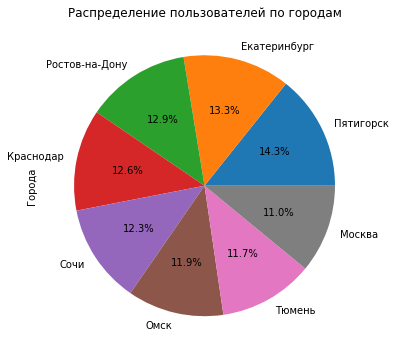

In [ ]:
# построим круговую диаграмму с расрпеделением пользователей по городам
(users_go['city']
    .value_counts()
    .plot(
        title='Распределение пользователей по городам',
        ylabel = 'Города',
        xlabel = 'Распределение пользователей',
        kind='pie',
        autopct='%1.1f%%',
        figsize=(6, 6)))

<AxesSubplot:title={'center':'Распределение пользователей по городам'}, ylabel='Города'>

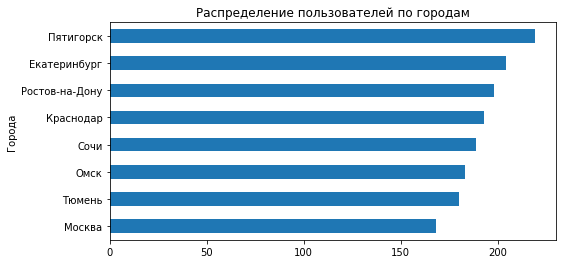

In [ ]:
# построим столбчатую диаграмму с расрпеделением пользователей по городам
(users_go['city']
    .value_counts(ascending=True)
    .plot(
        title='Распределение пользователей по городам',
        ylabel='Количество пользователей',
        xlabel='Города',
        kind = 'barh',
        figsize = (8, 4)))

<div class='alert alert-info'>
Сделал столбчатую диаграмму с ориентацией по горизонтали - так удобнее, на мой взгляд, чем классическая вертикальная ориентация.

**Вывод:**

Видим, что в нашем датафрейме всего представлено 8 городов:
 - Пользователи из Пятигорска составляют самое большое количество - их 14,28% от общего числа пользователей.
 - На втором месте пользователи из Екатеринбурга - 13,3% пользователей
 - На третьем месте Ростов-на-Дону - 12,91% пользователей
 - На четвером месте Краснодар - 12,58% пользователей
 - На пятом месте Сочи - 12,32% пользователей
 - На шестом месте Омск - 11,93% пользователей
 - На седьмом месте Тюмень - 11,93% пользователей
 - На восьмом месте Москва - 10,95% пользователей

##### Cоотношение пользователей с подпиской и без подписки

Аналогично предыдущему пункту сформируем таблицу с процентным соотношением исследуемых показателей и круговую диаграмму

In [ ]:
# сформируем отдельный датафрейм с распределеним пользователей по подпискам
subscriptions = pd.DataFrame (columns=['count', 'percent'])
# в основу положим количественное распределение пользователей
subscriptions['count'] = users_go['subscription_type'].value_counts()
# в столбец с процентом поместим значения долей пользователей к общей массе
subscriptions['percent'] = (subscriptions['count'] / users_go.shape[0] * 100).round(2)
subscriptions

,count,percent
free,835,54.43
ultra,699,45.57


<AxesSubplot:title={'center':'Распределение пользователей по типу подписки'}, ylabel='Тип подписки'>

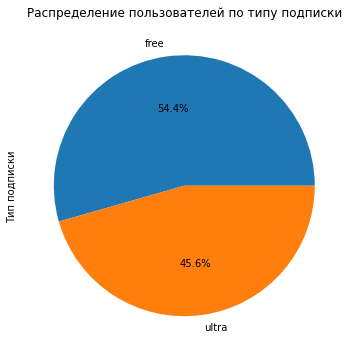

In [ ]:
# построим круговую диаграмму распределения пользователей по типу подписки
(users_go['subscription_type']
    .value_counts()
    .plot(
        title='Распределение пользователей по типу подписки',
        ylabel='Тип подписки',
        xlabel = 'Распределение пользователей',
        kind='pie',
        autopct='%1.1f%%',
        figsize=(6, 6)))

**Вывод:**

Видим, что в нашем датафрейме соотношение пользователей без подписки больше чем с подпиской: без подписки 54,43% пользователей, с подпиской - 45,57% пользователей

##### Возраст пользователей

In [ ]:
# сформируем отдельный датафрейм с распределением пользователей по возрасту
age = pd.DataFrame (columns=['count', 'percent'])
# в основу положим количественное распределение пользователей по возрасту
age['count'] = users_go['age'].value_counts()
# в столбец с процентом поместим значения долей возрастной группы к общей массе
age['percent'] = (age['count'] / users_go.shape[0] * 100).round(2)
age

,count,percent
25,145,9.45
24,132,8.60
26,131,8.54
23,129,8.41
27,119,7.76
22,119,7.76
28,112,7.30
21,93,6.06
20,71,4.63
30,68,4.43


In [ ]:
# выведем на экран статистические данные стобца с возрастным распределением
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Поскольку значений много, строить круговую диаграмму нет смысла, удобнее построить столбчатую диаграмму распределения

<AxesSubplot:title={'center':'Распределение пользователей по возрасту'}, xlabel='Возраст', ylabel='Количество пользователей'>

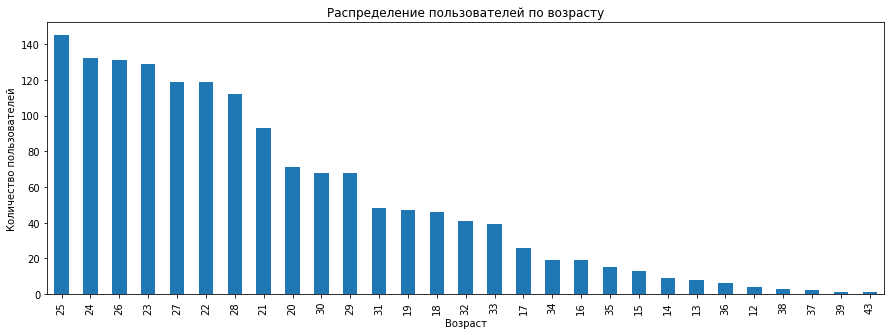

In [ ]:
# построим столбчатую диаграмму распределения возрастных групп с сортировкой
(users_go['age']
    .value_counts()
    .plot(
        title='Распределение пользователей по возрасту',
        ylabel='Количество пользователей',
        xlabel = 'Возраст',
        kind='bar',
        figsize=(15, 5)))

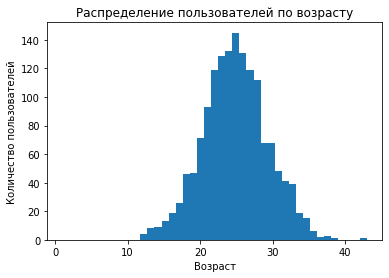

In [ ]:
users_go['age']
plt.hist(users_go['age'], bins=43, range=(1, 43))
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

<div class='alert alert-info'>
Построил классическую гистограмму, но она скорее показывает общую картину распределения, подтверждая, что у нас нормальное распределение. Опять же, если бы были отклонения от нормального - можно было бы предположить некорректность данных.

**Вывод:**

На основании исследованных данных мы видим, что:
 - Минимальный возраст пользователя - 12 лет
 - Максимальный возраст пользователя - 43 года
 - Средний возраст пользователей - 25 лет (округленно)
 - Больше всего пользователей в возрасте 25 лет, их доля 9,45%
 - Меньше всего пользователей в возрасте 39 и 43 года, их доля 0,07% (всего по одному человеку)

##### Распределение расстояния, которое пользователь преодолел за одну поездку

Здесь нет относительного соотношения друг с другом, поэтому собирать таблицу с процентным соотношением не будем

In [ ]:
# выведем на экран статистические данные столбца с дистанцией поездок
rides_go['distance'].describe()

count    18068.000000
mean      3071.159841
std       1116.831548
min          1.000000
25%       2543.750000
50%       3134.000000
75%       3777.000000
max       7212.000000
Name: distance, dtype: float64

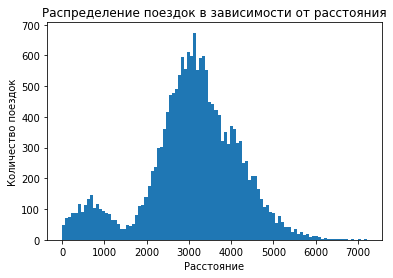

In [ ]:
# построим гистограмму распределения дистанций
plt.hist(rides_go['distance'], bins=100, range=(1, 7212))
plt.title('Распределение поездок в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

График соответствует нормальному распределению. Мы видим, что больше всего поездок в районе 3100, но по сути мы имеем два распределения: от 0 до 1500 и от 1500 до 5000 примерно. Можно изучить их по отдельности

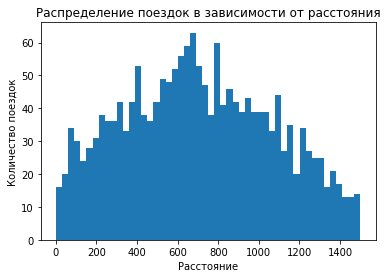

In [ ]:
# постоим гистограмму первой группы распределения дистанций
plt.hist(rides_go['distance'], bins=50, range=(1, 1500))
plt.title('Распределение поездок в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

В группе поездок до 1500 метров, чаще всего встречаются поездки на расстояние в 650 метров приблизительно. При этом мы видим пик в районе 50 метров - необходимо разобраться в причинах таких данных, кажется что нет большого смысла арендовать самокат для поездки на расстояние до 100 метров.

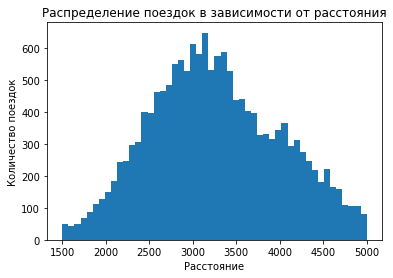

In [ ]:
# построим гистограмму второй группы распределения дистанций
plt.hist(rides_go['distance'], bins=50, range=(1500, 5000))
plt.title('Распределение поездок в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

 В группе поездок от 1500 до 5000 метров, чаще всего встречаются поездки нарасстояние в 3200 метров приблизительно.

**Вывод:**

Мы видим, что фактически у нас есть два совмещенных распределения со своими пиками:
 - расстояния от 0 до 1500
 - расстояния от 1500 до 5000

В этих двух распределениях, есть свои пики:
 - в первом распределении у нас пиковое значение в районе 650 метров - это наиболее популярное расстояние при поездках до 1,5 км
 - во втором распределении у нас пиковое значение в районе 3200 метров - это наиболее популярное расстояние при поездках от 1,5 до 5 км.

##### Продолжительность поездок

In [ ]:
# выведем на экрант статистические данные столбца с продолжительностью поездок
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

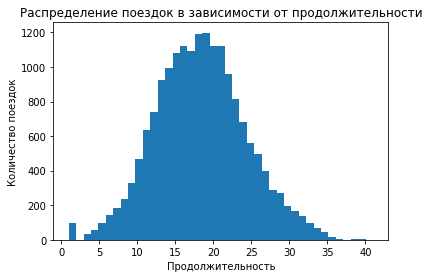

In [ ]:
# построим гистограмму распределения поездок по продолжительности
plt.hist(rides_go['duration'], bins=41)
plt.title('Распределение поездок в зависимости от продолжительности')
plt.xlabel('Продолжительность')
plt.ylabel('Количество поездок')
plt.show()

**Вывод:**

Видим, что чаще всего арендуют самокат для поездок в районе 18-19 минут, а также снова видим пик в районе 1-2 минут - хорошо бы отдельно разобраться с поездками до 5 минут - возможно тут какие-то технические аномалии.

In [ ]:
 rides_go[rides_go['duration'] < 3]

,user_id,distance,duration,date,month
6531,701,4197,1,2021-08-31,8
6570,704,4831,1,2021-10-14,10
6680,712,4685,1,2021-03-04,3
6695,713,5216,1,2021-02-25,2
6768,718,5198,1,2021-02-11,2
...,...,...,...,...,...
17004,1460,5532,1,2021-01-19,1
17242,1477,6725,1,2021-01-12,1
17314,1483,4446,1,2021-03-06,3
17505,1496,5723,1,2021-02-14,2


Если отдельно вывести строки со значениями менее 3, то можно увидеть, что 95 строк это всё поездки с продолжительностью 1 минута, с аномально высоким значением дсианции. Тут явно речь о технической ошибке и возможном сбое в работе приложения. Необходимо разобраться с логами в приложении по каждому такому факту.

<div class='alert alert-info'>
Видно, что речь о техническом сбое, надо смотреть логи приложения и выяснять в чем прична.

##### Общий вывод по исследовательскому анализу

Видим, что популярнее всего аренда самокатов в Пятигорске и других южных городах, но на втором месте Екатеринбург. Смущает что общее количество городов в датафрейме всего 8, при этом Москва на последнем месте. Чаще всего, при формировании естественных выборок Москва и Московская область на первом месте, по причине высокой плотности населения. А здесь мы наблюдаем обратную ситуацияю, что кажется не нормальным. Складывается впечатление, что мы имеем дело не с генеральной совокупностью, а с некорректно сделанной выборкой.

Вместе с тем, исходя из имеющихся данных, мы увидели, что доля пользователей без подписки несколько больше чем с подпиской 54,43% против 45,57%.

Возраст пользователей распределен от 12 до 43 лет, со средним возрастом 25 лет. Больше всего пользователей как раз в возрасте 25 лет, а меньше всего в возрасте 39 и 43 года

Все поездки по дистанции можно распределить на две группы: до 1,5 км и от 1,5 до 5 км. При этом в первой группе самая популярная дистанция около 650 м, а во  второй группе - около 3200 м.

Чаще всего пользователи арендуют самокаты на время в районе 18-19 минут, в остальнром длительность поездок распределяется по нормальному распределению.

#### Шаг 5. Объединение данных

На этом этапе необходимо:
 - Объединить данные о пользователях, поездках и подписках в один датафрейм.
 - Создать ещё два датафрейма из датафрейма, созданного на предыдущем этапе:
  - c данными о пользователях без подписки;
  - с данными о пользователях с подпиской.
 - Визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.

##### Объединение данных

In [ ]:
# сперва объединим таблицы с данными о пользователях и таблицу с данными подписках по типу подписок
data = pd.merge(users_go, sub_go, on='subscription_type')

In [ ]:
# затем добавим в общий датафрейм данные о поездках
data = pd.merge(rides_go, data, on='user_id')

In [ ]:
# выведем нга экран информацию о получившемся датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  int64         
 2   duration           18068 non-null  int64         
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 1.8+ MB


В итоге мы получили большую сводную таблицу со всеми данными на 18068 строк. Но в результате сведения могли появиться дубликаты, необходимо проверить.

In [ ]:
# проверим дубликаты в датафрейме
data.duplicated().sum()

0

К счастью, дубликатов не появилось, объединение прошло без проблем.
Далее создаем два новых датафрема, разделив когорты пользователей без подписки и пользователей с подпиской.

##### Разделение когорт

In [ ]:
# выделяем датафрейм с данными по когорте пользователей без подписки
data_free = data[data['subscription_type'] == 'free']
# выведем на экран информацию о датафрейме
data_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  int64         
 2   duration           11568 non-null  int64         
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
# выделяем датафрейм с данными по когорте пользователей с подпиской
data_ultra = data[data['subscription_type'] == 'ultra']
# выведем на экран информацию о датафрейме
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   int64         
 2   duration           6500 non-null   int64         
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 660.2+ KB


Любопытное наблюдение - количество поездок по тарифу без подписки почти в два раза выше количества поездок по подписке. Выведем их соотношение

<AxesSubplot:title={'center':'Распределение поездок по типу подписки'}, ylabel='Тип подписки'>

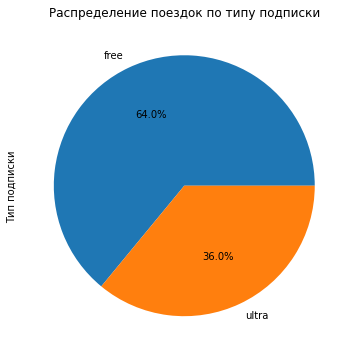

In [ ]:
# построим гистограмму распределения поездок пользователей с подпиской и без подписки
(data['subscription_type']
    .value_counts()
    .plot(
        title='Распределение поездок по типу подписки',
        ylabel='Тип подписки',
        xlabel = 'Распределение пользователей',
        kind='pie',
        autopct='%1.1f%%',
        figsize=(6, 6)))

Действительно 64% поездок совершается без подписки, и только 36% с подпиской.

##### Визуализация данных по когортам

Для начала построим совмещенные гистограммы по обеим когортам, чтобы увидить их общее соотношение

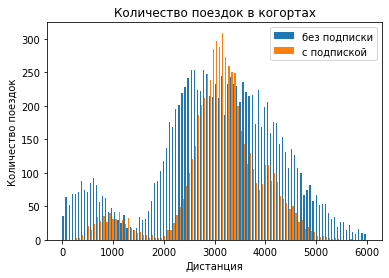

In [ ]:
plt.hist([data_free['distance'], data_ultra['distance']], bins=100, range=(1,6000), label=['без подписки', 'с подпиской'])
plt.legend(loc='upper right')
plt.title('Количество поездок в когортах')
plt.xlabel('Дистанция')
plt.ylabel('Количество поездок')
plt.show()

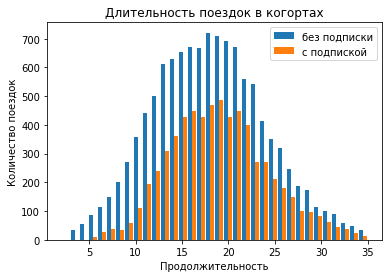

In [ ]:
plt.hist([data_free['duration'], data_ultra['duration']], bins=34, range=(2, 35), label=['без подписки', 'с подпиской'])
plt.legend(loc='upper right')
plt.title('Длительность поездок в когортах')
plt.xlabel('Продолжительность')
plt.ylabel('Количество поездок')
plt.show()

###### Данные по когорте пользователей без подписки

In [ ]:
# выведем на экран статистические данные столобца с дистанцией поездок
data_free['distance'].describe()

count    11568.000000
mean      3045.992911
std       1246.174341
min          1.000000
25%       2367.000000
50%       3115.000000
75%       3906.000000
max       7212.000000
Name: distance, dtype: float64

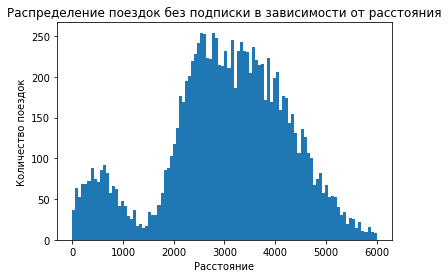

In [ ]:
# построим гистограмму распределения дистанции поездок
plt.hist(data_free['distance'], bins=100, range=(1, 6000))
plt.title('Распределение поездок без подписки в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Снова видим две группы - гипотеза работает для пользователей без подписки. Повторим упражнение, с разделением на две группы.

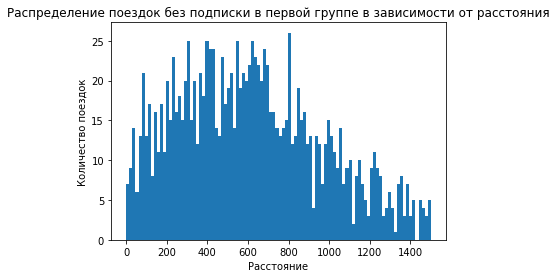

In [ ]:
# построим гистограмму распределения дистанций в первой группе
plt.hist(data_free['distance'], bins=100, range=(1, 1500))
plt.title('Распределение поездок без подписки в первой группе в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Видим что в этой группе самым популярным является расстояние 800-815 м, затем примерно с одинаковой частостой являются популярными расстояния около 100, 250, 300, 400, 450, 500, 550, 600 и 650 метров.

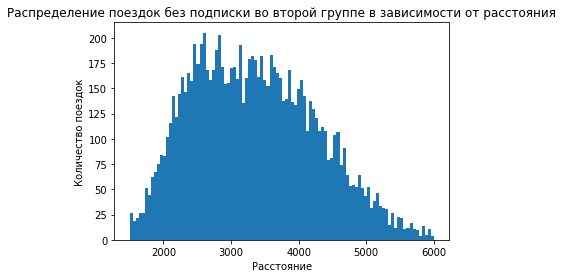

In [ ]:
# построим гистограмму распределения дистанций во второй группе
plt.hist(data_free['distance'], bins=100, range=(1500, 6000))
plt.title('Распределение поездок без подписки во второй группе в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Видим, что в этой группе самым популярным является расстояние в районе 2500, затем около 2750 и 3000 метров

In [ ]:
# выведем на экран статистические данные столбца с продолжительностью поездок
data_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

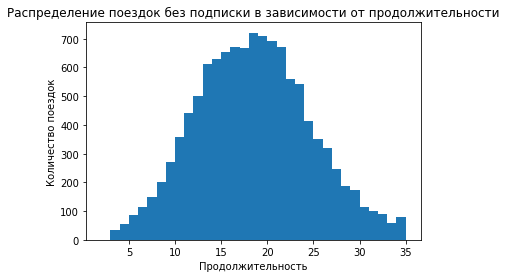

In [ ]:
# построим гистограмму распределения продолжительности поездок
plt.hist(data_free['duration'], bins=33, range=(2, 35)) # сразу отсек аномалию в 1 минуту
plt.title('Распределение поездок без подписки в зависимости от продолжительности')
plt.xlabel('Продолжительность')
plt.ylabel('Количество поездок')
plt.show()

Видим нормальное распределение. Самым популярными являются поездки в районе 17-18 минут. В остальном распределение нормальное.

**Вывод по когорте**

С точки зрения расстояния, здесь тоже видим две группы (до 1500 и свыше 1500). В первой группе наиболее популярным расстоянием для поездок является расстояние 800-815 метров, однако также видим что очень популярны и меньшие расстояния от 100 до 600 с градациями по 50 метров. Также видим, что самое популярное время одной поездки снова в районе 17-18 минут.

###### Данные по когорте пользователей с подпиской

In [ ]:
# выведем на экран статистические данные столбца с дистанциями
data_ultra['distance'].describe()

count    6500.000000
mean     3115.949231
std       836.894838
min       245.000000
25%      2786.000000
50%      3149.000000
75%      3561.000000
max      5700.000000
Name: distance, dtype: float64

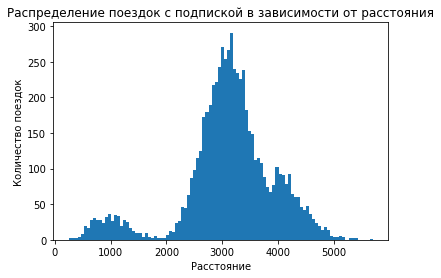

In [ ]:
# построим гистограмму распределения расстояний поездок
plt.hist(data_ultra['distance'], bins=100, range=(245, 5700))
plt.title('Распределение поездок с подпиской в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Видим, что тут уже разделение на три условные группы по пикам: до 2000, до 3800 и от 3800

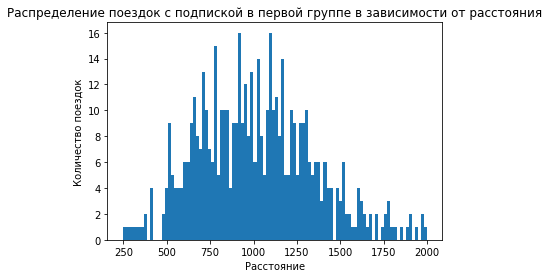

In [ ]:
# постротим гистограмму распределения в первой группе
plt.hist(data_ultra['distance'], bins=100, range=(245, 2000))
plt.title('Распределение поездок с подпиской в первой группе в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

В первой группе самые популярные расстояния в районе 800 и 1100 метров. Также видим довольно высокую популярность у расстояний  в районе 760, 900 и 1125. Иными словами наиболее популярны у пользователей с подпиской в первой группе расстояния в районе одного километра.

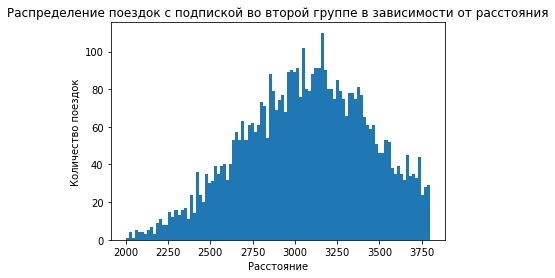

In [ ]:
# построим гистограмму распределения во второй группе
plt.hist(data_ultra['distance'], bins=100, range=(2000, 3800))
plt.title('Распределение поездок с подпиской во второй группе в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Во второй группе наиболее популярны поездки в районе 3100 метров.

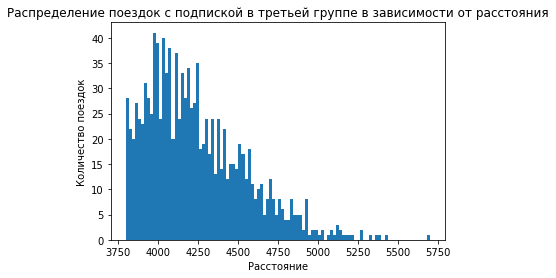

In [ ]:
# построим гистограмму распределения в третьей группе
plt.hist(data_ultra['distance'], bins=100, range=(3800, 5700))
plt.title('Распределение поездок с подпиской в третьей группе в зависимости от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

В третьей группе наиболее популярны расстояния в районе 4000 и 4100 метров

In [ ]:
# выведем статистические данные столца с продолжительностью поездок
data_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

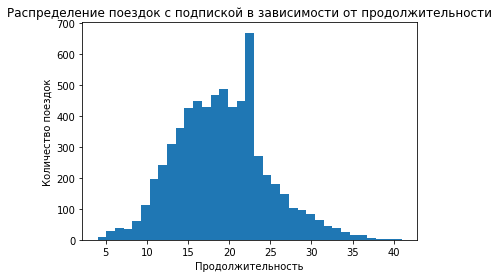

In [ ]:
# построим гистограмму распределения поездок по продолжительности
plt.hist(data_ultra['duration'], bins=35, range=(4, 41))
plt.title('Распределение поездок с подпиской в зависимости от продолжительности')
plt.xlabel('Продолжительность')
plt.ylabel('Количество поездок')
plt.show()

Видим, что тут есть резкий пик - 22 минуты, именно такое время поездки в этой когорте самое популярное

**Вывод по когорте**

С точки зрения расстояния, здесь видим уже три группы (до 2000, до 3800 и от 3800). В первой группе наиболее популярным расстоянием для поездок является расстояние 800 и 1100 метров, однако также видим что очень популярны и другие расстояния от 760 до 1125 метров. В третьей группе наиболее популярными являются расстояния 4000 и 4100 метров. Также видим, что самое популярное время одной поездки снова в районе 22 минут.

**Общий вывод по когортам**

Видим, что в целом пользователи с подпиской чаще всего проезжают расстояние больше, чем пользователи без подписки, и арендуют самокат на время дольше, чем пользователи без подписки. Кроме того, аномалия в видле 1 минуты с аномальными значениями дистанции присутствует только у пользователей без подписки. У пользователей с подпиской минимальное значение - 4 минуты.

#### Шаг 6. Подсчёт выручки

На этом этапе нам необходимо:
 - Создать датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из предыдущего шага. В этом датафрейме нужно:
  - найти суммарное расстояние,
  - количество поездок
  - суммарное время для каждого пользователя за каждый месяц.
 - В этот же датафрейм нужно добавить столбец с помесячной выручкой, которую принёс каждый пользователь.

##### Создаем датафрейм для рассчетов

In [ ]:
# создаем сводную таблицу с данными о номере месяца, количестве поездок,
# суммарной дистанции и тарификации поездок
data_billing = data.pivot_table(
    index=('user_id', 'month'),
    values=(
        'distance',
        'duration',
        'subscription_type',
        'minute_price',
        'start_ride_price',
        'subscription_fee'),
    aggfunc=({'distance':{'count', 'sum'},
              'duration':'sum',
              'minute_price': 'first',
              'start_ride_price':'first',
              'subscription_type': 'first',
              'subscription_fee':'first'}))
data_billing

distance        duration minute_price start_ride_price  \
                 count    sum      sum        first            first   
user_id month                                                          
1       1            2   7028       42            6                0   
        4            1    755        7            6                0   
        8            2   6724       46            6                0   
        10           2   5811       32            6                0   
        11           3   7005       56            6                0   
...                ...    ...      ...          ...              ...   
1534    6            2   3411       26            8               50   
        8            2   7623       48            8               50   
        9            1   4929       23            8               50   
        11           4  13353       78            8               50   
        12           1   2372       16            8               50   

              subscription_fee subscription_type  
                         first             first  
user_id month                                     
1       1                  199             ultra  
        4                  199             ultra  
        8                  199             ultra  
        10                 199             ultra  
        11                 199             ultra  
...                        ...               ...  
1534    6                    0              free  
        8                    0              free  
        9                    0              free  
        11                   0              free  
        12                   0              free  

[11331 rows x 7 columns]

In [ ]:
# приведем в порядок названия столбцов
data_billing.columns = [
    'count',
    'dist_sum',
    'dur_sum',
    'minute_price',
    'start_ride_price',
    'subscription_fee',
    'subscription_type']
data_billing

count  dist_sum  dur_sum  minute_price  start_ride_price  \
user_id month                                                             
1       1          2      7028       42             6                 0   
        4          1       755        7             6                 0   
        8          2      6724       46             6                 0   
        10         2      5811       32             6                 0   
        11         3      7005       56             6                 0   
...              ...       ...      ...           ...               ...   
1534    6          2      3411       26             8                50   
        8          2      7623       48             8                50   
        9          1      4929       23             8                50   
        11         4     13353       78             8                50   
        12         1      2372       16             8                50   

               subscription_fee subscription_type  
user_id month                                      
1       1                   199             ultra  
        4                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        11                  199             ultra  
...                         ...               ...  
1534    6                     0              free  
        8                     0              free  
        9                     0              free  
        11                    0              free  
        12                    0              free  

[11331 rows x 7 columns]

In [ ]:
# создаем столбец с рассчетом выручки по месяцу на данных о тарифах
data_billing['billing'] = (
    data_billing['start_ride_price'] * data_billing ['count'] +
    data_billing['minute_price'] * data_billing['dur_sum'] +
    data_billing['subscription_fee'])
data_billing

count  dist_sum  dur_sum  minute_price  start_ride_price  \
user_id month                                                             
1       1          2      7028       42             6                 0   
        4          1       755        7             6                 0   
        8          2      6724       46             6                 0   
        10         2      5811       32             6                 0   
        11         3      7005       56             6                 0   
...              ...       ...      ...           ...               ...   
1534    6          2      3411       26             8                50   
        8          2      7623       48             8                50   
        9          1      4929       23             8                50   
        11         4     13353       78             8                50   
        12         1      2372       16             8                50   

               subscription_fee subscription_type  billing  
user_id month                                               
1       1                   199             ultra      451  
        4                   199             ultra      241  
        8                   199             ultra      475  
        10                  199             ultra      391  
        11                  199             ultra      535  
...                         ...               ...      ...  
1534    6                     0              free      308  
        8                     0              free      484  
        9                     0              free      234  
        11                    0              free      824  
        12                    0              free      178  

[11331 rows x 8 columns]

In [ ]:
# выведем на экран статистические данные столбца с выручкой
data_billing['billing'].describe()

count    11331.000000
mean       342.303504
std        153.875346
min         58.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: billing, dtype: float64

In [ ]:
# выведем на экран сумму выручки от пользователей с подпиской
data_billing.loc[data_billing['subscription_type'] == 'ultra', 'billing'].sum()

1644537

In [ ]:
# выведем на экран сумму выручки от пользователей без подписки
data_billing.loc[data_billing['subscription_type'] == 'free', 'billing'].sum()

2234104

Самая дешевая поездка - 58 рублей, самая дорогая - 1444 рубля. Средняя стоимость поездок 342 рубля, а медианная 319 рублей. Общая выручка от пользователей с подпиской составляет 1644537 рублей. Общая выручка от пользователей без подписки составляет 2234104.

#### Шаг 7. Проверка гипотез

На этом этапе нам необходимо проверить 4 гипотезы:
1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
4. Снизилось ли количество обращений в техподдержку, после обновлений сервиса?

##### Гипотеза: Тратят ли пользователи с подпиской больше времени на поездки?

Сформулируем гипотезы для проверки:
 - H0: Средняя продолжительность поездок пользователей с подпиской равна средней продолжительности поездок пользователей без подписки
 - Н1: Средняя продолжительность поездок пользователей с подпиской больше средней продолжительности поездок пользователей без подписки

In [ ]:
# задаем конвенциальное значение статистической значимости в 5%
alpha = 0.05

# используем метод для проверки гипотезы двух независимых совокупностей
results = st.ttest_ind(
    data_ultra['duration'],
    data_free['duration'],
    equal_var=True,
    alternative='greater')

# выведем на экран значение вероятности
display('p-значение:', results.pvalue)

# выведем на экран подученный результат проверки гипотезы
if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

2.4959453720736625e-34

'Отвергаем нулевую гипотезу'

**Вывод по гипотезе**

В результате проверки гипотезы мы отвергли нулевую гипотезу. Таким образом, статистически можно утверждать, что средняя продолжительность поездок пользователей с подпиской больше, чем средняя продолжительность поездок пользователей без полписки. Это подтверждает факты выявленные нами ранее при построении гистограмм: средняя продолжительность поездок пользователей с подпиской 19.0, а средняя продолжительность поездок пользователей без подписки 17.8

##### Гипотеза: Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

**Вводные:** Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Именно поэтому мы сраниваем с этим расстоянием - более длинные поездки будут приводить к сильному износу самокатов.

Сформулируем гипотезы для проверки:
- Н0: Среднее расстояние поездок пользователей с подпиской равно оптимальному расстоянию в 3130 метров.
- Н1: Среднее расстояние поездок пользователей с подпиской больше оптимального в 3130 метров.

In [ ]:
# задаем значение проверяемой дистанции
distance = 3130
# задаем конвенциальное значение статистической значимости в 5%
alpha = 0.05

#используем метод для проверки односторонней гипотезы в правую сторону
results = st.ttest_1samp(
    data_ultra['distance'],
    distance,
    alternative='greater')

#выведем на экран значение вероятности
display('p-значение:', results.pvalue)

# выведем на экран результат проверки гипотезы
if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

0.9120422337080507

'Не получилось отвергнуть нулевую гипотезу'

С точки зрения текущей формулировки гипотезы, мы не смогли опровергнуть нулевую гипотезу, но это значит только то, что в результате т-теста мы не смогли доказать, что средняя дистанция пользователей с подпиской, больше 3130 метров. Но если мы вернемся к данным, которые устанавливали с помощью гистограмм, то увидим, что средняя дистанция пользователей с подпиской составляет 3115.94.

Попробуем сформулировать обратную гипотезу

Сформулируем гипотезы для проверки:

- Н0: Среднее расстояние поездок пользователей с подпиской равно оптимальному расстоянию в 3130 метров.
- Н1: Среднее расстояние поездок пользователей с подпиской меньше оптимального в 3130 метров.

In [ ]:
# задаем значение проверяемой дистанции
distance = 3130
# задаем конвенциальное значение статистической значимости в 5%
alpha = 0.05

#используем метод для проверки односторонней гипотезы в левую сторону
results = st.ttest_1samp(
    data_ultra['distance'],
    distance,
    alternative='less')

#выведем на экран значение вероятности
display('p-значение:', results.pvalue)

# выведем на экран результат проверки гипотезы
if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

0.08795776629194929

'Не получилось отвергнуть нулевую гипотезу'

<div class='alert alert-info'>
Хотя достаточно и одной гипотезы, я осознанно сделал проверку и второй гипотезы, потому что заказчику иногда, на самом деле, бывает нужно немного шире исследование, чем изначально ставят задачу. Поэтому сразу и обратную гипотезу рассмотрел, с точки зрения того, что возможно получится, исходя из средней дистанции, закладывать меньшие расходы на обслуживание самокатов. По факту сэкономить на обслуживании не получится, так как и обратная гипотеза приводит к отказу от альтернативной гипотезы. То есть все равно расходы надо расчитывать исходя из оптимальной дистанции

B снова мы не смогли отвергнуть нулевую гипотезу, однако в этот раз p-значение немного ближе к конвенциональному значению уровня значимости в 5%

**Вывод по гипотезе**

В результате проверки гипотезы мы не отвергли нулевую гипотезу. Это не значит, что мы ее подтвердили, но мы ее не отвергли. Фактически мы видим, что среднее значение при проверке гистограмм отличается от контрольного в 3130 (3115.94), но отличается незначительно.

Так что, в целом, не смотря на более длительное использование самокатов пользователями с подпиской, мы видим, что их активное использование в среднем не превышает оптимального для чрезмерного износа техники, а это именна та цель, которую нам нужно установить проверкой этой гипотезы.

#####  Гипотеза: Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Сформулируем гипотезы для проверки:

- Н0: Помесячная средняя выручка от пользователей с подпиской равна помесячной средней выручке от пользователей без подписки.
- Н1: Помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки.

In [ ]:
# задаем конвенциальное значение статистической значимости в 5%
alpha = 0.05

# используем метод для проверки гипотезы двух независимых совокупностей
results = st.ttest_ind(
    data_billing.loc[data_billing['subscription_fee'] > 0, 'billing'],
    data_billing.loc[data_billing['subscription_fee'] == 0, 'billing'],
    equal_var=True,
    alternative='greater')

#выведем на экран значение вероятности
display('p-значение:', results.pvalue)

# выведем на экран результат проверки гипотезы
if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

1.8850394384715216e-31

'Отвергаем нулевую гипотезу'

**Вывод по гипотезе**

В результате проверки гипотезы мы отвергли нулевую гипотезу. То есть, мы подтвердили, что средняя помесячная выручка пользователей выше чем средняя помесячная выручка пользователей без подписки. Косвенно об этом свидетельствуют и те факты, что среднее расстояние, проезжаемое пользователями с подпиской, больше, чем у пользователей без подписки, а так же время аренды самоката у пользователей с подпиской дольше, чем у пользователей без подписки - это неизбежно должно было повлиять на помесячную среднюю выручку.

Однако, не стоит забывать, что общее количество поездок у пользователей без подписки больше, чем у пользователей с подпиской и общая выручка от пользователей без подписки выше, чем от пользователей с подпиской.

##### Гипотеза: Снизилось ли количество обращений в техподдержку, после обновлений сервиса?

**Вводные:** техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

Поскольку у нас на самом деле нет файла с данными о количестве обращений до обновления и после, мы имеем дело с гипотетической ситуацией.
Так как, мы имеем дело с зависимыми (парными) выборками, поскольку речь об изменении параметров выборки через определенное время, для проверки гипотезы о равенстве среднего генеральной совокупности для зависимых (парных) выборок, применяется метод ***scipy.stats.ttest_rel()***.
Для проверки, что истинное среднее значение генеральной выборки до изменения больше, чем после изменения следует указать ***alternative='less'***

##### Общие выводы по гипотезам

1. Мы смогли подтвердить первую гипотезу и доказали, что пользователи с подпиской в среднем тратят больше времени на поездки - они на большее время арендуют самокаты.
2. Мы доказали, что среднее расстояние не превышает 3130 метров и поездки пользователей с подпиской в целом не приводят к чрезмерному износу самокатов.
3. Мы доказали, что помесячная выручка от пользователей с подпиской в среднем выше, чем от пользователей без подписки. Однако при принятии решения на основании этой гипотезы, стоит помнить, что частоста поездок  и общая вырука от пользователей без подписки больше, чем от пользователей с подпиской.
4. Для доказательства гипотезы о снижении  количества обращений в техподдержку, необходимо использовать метод ***scipy.stats.ttest_rel()*** с параметром ***alternative='less'***

#### Шаг 8. Распределения

На этом шаге нам необходимо построить два распределения для описания ситуаций отдела маркетинга.

##### Акция с раздачей промокодов на один бесплатный месяц подписки

**Водные:**

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

**Задача:** Подобрать параметры распределения, описывающего эту ситуацию, построить график распределения и сформулировать ответ на вопрос о минимальном количестве промокодов.

Поскольку по ранее проведенному эксперименту мы уже имеем определенные данные, построим биноминальное распределение, так как у нас всего два возможных исхода: продление подписки и не продление подписки. Для биноминального распределения используем следующие параметры:
 - n = 1000. Ранее мы уже установили веротность успеха в 10%, при этом нам надо, чтобы как минимум 100 клиентов продлили подписку. Таким образом 10х100=1000 минимальное количество необходимых экспериментов, от которого будем вести отсчет
 - p = 0.1 по данным ранее проведенного эксперимента мы уже знаем, что вероятность успеха 10%
 - control_exp = 100 - контрольное минимальное значение успешных экспериментов которое нам необходимо получить
 - control_cdf = 0.05 контрольное значение куммулятивной функции, по которому будем определять порог успешности - 5% По условиям нам нужно, чтобы вероятность провала плана была меньше, либо равно 5%

'Чтобы вероятность не выполнить план была меньше либо равна 5%, необходимо раздать 1172 промокодов'

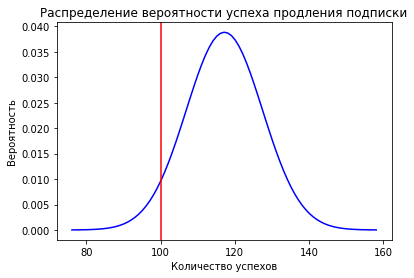

In [ ]:
# задаем начальное количество экспериментов
n = 1000
# задаем значение вероятности успеха
p = 0.1
# зааем значение контрольного количества успехов
control_exp = 100
# задаем контрольное значение куммулятивной функции распределения
control_cdf = 0.05

# запустим условный цикл, до достижения необходмого условия: значение cdf() >= control_cdf
while control_cdf < binom.cdf(control_exp, n, p):
    n += 1

# выведем на экран полученный результат
display(f'Чтобы вероятность не выполнить план была меньше либо равна 5%, необходимо раздать {n} промокодов')

# посчитаем математическое ожидание
mu = n * p
# посчитаем стандартное отклонение
sigma = (n * p * (1 - p))**0.5

# потроим график распределения
arange = np.arange((mu - 4 * sigma), (mu + 4 * sigma), 1)

plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.axvline(x=control_exp, color='red')
plt.title('Распределение вероятности успеха продления подписки')
plt.xlabel('Количество успехов')
plt.ylabel('Вероятность')
plt.show()

**Вывод:**

С учетом вводных, при конверсии (вероятности успеха) 10%, чтобы не менее 100 действующих клиентов продлили подписку, и вероятности невыполнения плана не больше 5% (меньше, либо равно 5%), отделу маркетинга необходимо разослать минимум 1172 промокода на бесплатный месяц подписки в рамках маркетинговой акции.

##### Рассылка клиентам push-уведомлений в мобильном приложении

**Водные:**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений.

**Задача:** С помощью аппроксимации построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. .

Снова имеем дело с биноминальным распределением, так как у нас только два возможных исхода: откроют уведомление / не откроют уведомление. Для биноминального распределения используем следующие параметры:
 - n = 1000000. Поскольку планируется разослать 1 млн уведомлений, то это число берем как количество экспериментов.
 - p = 0.4 У нас уже известно, что конверсия (вероятность успеха) составляет  40%, поэтому берем значение вероятности 0.4
 - control_exp = 399500, поскольку задача оценить вероятность того, что откроют уведомления не более 399,5 тыс пользователей, это значение берем как контрольное.

'Вероятность открытия меньше, либо равно 399,5 тыс сообщений: 15.0%'

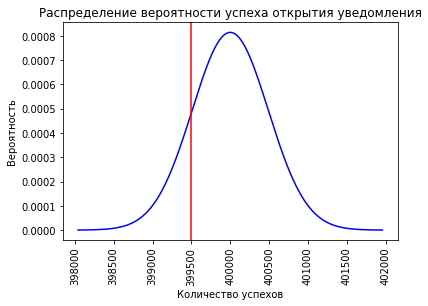

In [ ]:
# задаем требуемое количество экспериментов
n = 1000000
# задаем значение вероятности успеха
p = 0.4
# задаем контрольное количество успешных экспериментов
control_exp = 399500

# посчитаем математичесое ожидание
mu = n * p
# посчитаем стандартное отклонение
sigma = (n * p * (1 - p))**0.5

# посчитаем нормальнео распределение
distr = st.norm(mu, sigma)

# считаем вероятность хвоста слева от контрольного значения
result = distr.cdf(control_exp)
# выведем на экран полученный результат
display(f'Вероятность открытия меньше, либо равно 399,5 тыс сообщений: {result.round(2)*100}%')

# построим график распределения
arange = np.arange((mu - 4 * sigma), (mu + 4 * sigma), 1)

plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.xticks(rotation=90)
plt.axvline(x=control_exp, color='red')
plt.title('Распределение вероятности успеха открытия уведомления')
plt.xlabel('Количество успехов')
plt.ylabel('Вероятность')
plt.show()

**Вывод:**

С учетом вводных, при конверсии (вероятности успеха) 40%, и рассылке 1 млн уведомлений вероятность, что уведомления откроют 399,5 и менее пользователей, на самом деле составляет 15%. С высокой долей вероятности откроют сообщения большее количество пользователей.

#### Общие выводы по итогам исследовательской работы

**Общий вывод**

Для исследовательской работы нам были предоставлены данные сервиса аренды самокатов GoFast. Были переданы данные о некоторых пользователях из нескольких городов, а также об их поездках.

В качестве исследовательской была поставлена задача: проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Вся исследовательская работа строилась из нескольких этапов:
1. Загрузка данных из файлов: users_go.csv, rides_go.csv, subscriptions_go.csv.
2. Обзор данных и выявление ошибок и аномалий
3. Предобработка данных и исправление ошибок
4. Анализ данных после предобработки
5. Объедините данные о пользователях, поездках и подписках в один датафрейм и создание датафреймов о пользователях с подпиской и пользователях без подписки
6. Подсчет выручки генерируемой пользователями
7. Проверка гипотез
8. Расчет распределений
9. Общие выводы по итогам исследовательской работу

<h5>Обзор данных</h5>
При обзоре данных, были выявлены нехарактерные дубли, похожие на искуственное "заражение данных".

***Необходимо получить комментарии о причинах их появления.***

<h5>Предобработка данных и исправление ошибок</h5>
В ходе предобработки данных були удалены дубликаты, форматы даты привелены в норму, данные о расстоянии и времени округлены, добавлен столбец с указанием месяца поездки, для дальнейшей аналитики.

<h5>Анализ данных после предобработки</h5>
В ходе исследовательского анализа данных, было необходимо описать и визуализировать общую информацию о пользователях и поездках:
 - частота встречаемости городов;
 - соотношение пользователей с подпиской и без подписки;
 - возраст пользователей;
 - расстояние, которое пользователь преодолел за одну поездку;
 - продолжительность поездок.

Было установлено, что популярнее всего аренда самокатов в Пятигорске и других южных городах, но на втором месте Екатеринбург. Смущает, что общее количество городов в датафрейме всего 8, при этом Москва на последнем месте. Чаще всего, при формировании естественных выборок Москва и Московская область на первом месте, по причине высокой плотности населения. А здесь мы выявили обратную ситуацияю, что кажется не нормальным. Складывается впечатление, что мы имеем дело не с генеральной совокупностью, а с некорректно сделанной выборкой. ***Необходимо получить пояснения от команды о способе формирования выборки, в связи с подозрением в некорректности предоставленных данных.***

Вместе с тем, исходя из имеющихся данных, мы увидели, что доля пользователей без подписки несколько больше, чем с подпиской 54,43% против 45,57%.

Установлено, что возраст пользователей распределен от 12 до 43 лет, со средним возрастом 25 лет. Больше всего пользователей как раз в возрасте 25 лет, а меньше всего в возрасте 39 и 43 года.

Все поездки по дистанции можно распределить на две группы: до 1,5 км и от 1,5 до 5 км. При этом, в первой группе самая популярная дистанция около 650 м, а во второй группе - около 3200 м.

Чаще всего пользователи арендуют самокаты на время в районе 18-19 минут, в остальном длительность поездок распределяется по нормальному распределению.

<h5>Объединение данных</h5>
На этом этапе было необходимо:
 - Объединить данные о пользователях, поездках и подписках в один датафрейм.
 - Создать ещё два датафрейма из датафрейма, созданного на предыдущем этапе:
  - c данными о пользователях без подписки;
  - с данными о пользователях с подпиской.
 - Визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.

В результате было установлено, что:
 - количество поездок по тарифу без подписки почти в два раза выше количества поездок по подписке
 - в когорте пользователей без подписки:
  - установлены две группы распределения поездок по расстоянию: до 1500 метров и свыше 1500 метров. В каждой группе установлены пиковые значения: 800-815 для первой группы и 2500 для второй группы. Распределение по группам дает более объективную картину, чем подсчет среднего значения по всей когорте.
  - установлено, что чаще всего ареднуют самокат на поездки длительностью около 17-18 минут. Также есть аномальный пик в районе 1 минуты. ***Необходимо с командой отдельно изучить аномально короткие поездки - возможно причина в технических ошибках бронирования.***
 - в когорте пользователей с подпиской:
  - установлены уже три условные группы распределения поездок по расстоянию: до 2000, 2000 - 3800 и от 3800. В каждой группе установлены свои пиковые значения: 800 и 1100 метров в первой группе, 3100 во второй группе, 4000 и 4100 метров в третьей группе
  - установлено, что чаще всего пользователи с побпиской арендуют самокат на поездки длительностью 18-19 минут.

Таким образом, продолжительность поездок и их расстояние у пользователей с подпиской чаще всего больше чем у пользователей без подписки

<h5>Подсчет выручки генерируемой пользователями</h5>
На этом этапе мы:
 - Создали датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из предыдущего шага. В этом датафрейме:
  - нашли суммарное расстояние по каждому пользователю помесячно,
  - опредлелили количество поездок каждого пользователя помесячно,
  - определили суммарное время поездок для каждого пользователя помесячно
 - В этот же датафрейм добавили столбец с помесячной выручкой, которую принёс каждый пользователь.

В результате мы определили, что самая дешевая поездка - 58 рублей, самая дорогая - 1444 рубля. Средняя стоимость поездок 342 рубля, а медианная 319 рублей. Общая выручка от пользователей с подпиской составляет 1644537 рублей. Общая выручка от пользователей без подписки составляет 2234104.

<h5>Проверка гипотез</h5>
На этом этапе нам необходимо было проверить 4 гипотезы:
 - Тратят ли пользователи с подпиской больше времени на поездки?
 - Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
 - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
 - Снизилось ли количество обращений в техподдержку, после обновлений сервиса?

**По первой гипотезе** мы статистически подтвердили, что средняя продолжительность поездок пользователей с подпиской больше, чем средняя продолжительность поездок пользователей без подписки. Это же подтверждает факты выявленные ранее при построении гистограмм: средняя продолжительность поездок пользователей с подпиской 19.0, а средняя продолжительность поездок пользователей без подписки 17.8

**По второй гипотезе** мы подтвердили, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, однако мы не подтверди гипотезу напрямую, а не опровергли ее. Фактически мы увидели, что среднее значение при проверке гистограмм отличается от контрольного в 3130 (3115.94), но отличается незначительно. Так что, в целом, не смотря на более длительное использование самокатов пользователями с подпиской, мы видим, что их активное использование в среднем не превышает оптимального для чрезмерного износа техники, а это именна та цель, которую нам нужно установить проверкой этой гипотезы.

**По третьей гипотезе** мы подтвердили, что средняя помесячная выручка пользователей выше, чем средняя помесячная выручка пользователей без подписки. Косвенно об этом свидетельствуют и те факты, что среднее расстояние, проезжаемое пользователями с подпиской, больше, чем у пользователей без подписки, а так же время аренды самоката у пользователей с подпиской дольше, чем у пользователей без подписки - это неизбежно должно было повлиять на помесячную среднюю выручку. Однако, не стоит забывать, что общее количество поездок у пользователей без подписки больше, чем у пользователей с подпиской и общая выручка от пользователей без подписки выше, чем от пользователей с подпиской.

**По четвертой гипотезе** мы определили, что раз реь идет о зависимых выборках, мы будем применять метод ***scipy.stats.ttest_rel()***. Для проверки, что истинное среднее значение генеральной выборки до изменения больше, чем после изменения будем указывать параметр ***alternative='less'***.

<h5>Расчет распределений</h5>
На этом шаге нам было необходимо построить два распределения для описания ситуаций отдела маркетинга.

**По первой ситуации** мы определили, что при конверсии (вероятности успеха) 10%, чтобы не менее 100 действующих клиентов продлили подписку, и вероятности невыполнения плана не больше 5% (меньше, либо равно 5%), отделу маркетинга необходимо разослать минимум 1172 промокода на бесплатный месяц подписки в рамках маркетинговой акции.

**По второй ситуации** мы определили, что при конверсии (вероятности успеха) 40%, и рассылке 1 млн уведомлений вероятность, что уведомления откроют 399,5 и менее пользователей, составляет 15%. С высокой долей вероятности откроют сообщения большее количество пользователей.

<h5>Рекомендации</h5>
По результатам исследовательской работы можно дать следующие рекомендации:

1. Необходимо с командой разобраться в механике формирования выгрузки в файлах. Наличие случайных дубликатов в файле с данными пользвателей наводит на подозрения в искусственном "заражении данных".
2. Вместе с командой разобраться в механике формирования выгрузки данных по городам: из-за того, что данные по Москве составляют наименьшую долю, есть подозрение, что выборка была сделана некорректно и является нерепрезентативной, что полностью нивелирует выводы при проверке гипотез и построении распределений - они могут быть некорректными.
3. Вместе с командой изучить причины аномально коротких поездок по времени и расстоянию, возможно имеет место техническая ошибка или проблемы с некорректной работой сервиса.
4. При принятии решений на основе данных о помесячной выручке пользователей с подпиской и без, учитывать не только эти параметры, но и общую долю выручки пользователей с подпиской и без подписки, а также помесячную долю выручки пользователей с подпиской и без подписки.